   unnamed:_0 country                                         track_name  \
0           0  Global                               Standing Next to You   
1           1  Global                                             greedy   
2           2  Global                                        Si No Estás   
3           3  Global                Seven (feat. Latto) (Explicit Ver.)   
4           4  Global  Is It Over Now? (Taylor's Version) (From The V...   

      artist_name               album_name  popularity        date markets  \
0       Jung Kook                   GOLDEN          91  2023-11-03      AR   
1      Tate McRae                   greedy         100  2023-09-15      AR   
2  iñigo quintero              Si No Estás          99  2022-09-23      AR   
3       Jung Kook                   GOLDEN          82  2023-11-03      AR   
4    Taylor Swift  1989 (Taylor's Version)          93  2023-10-26      AR   

   danceability  acousticness  ...  energy  instrumentalness  key  livenes

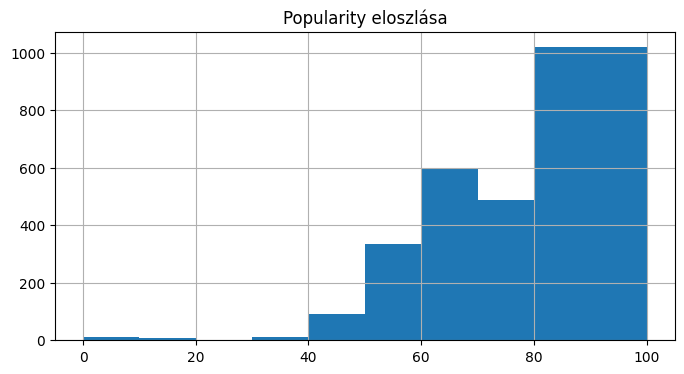

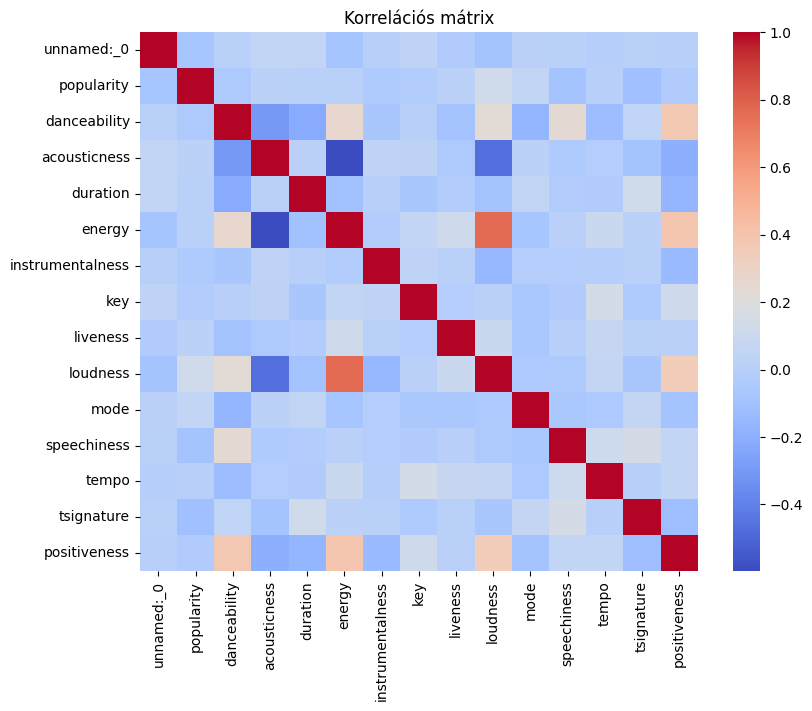

Osztályarány:
y
0    2831
1     758
Name: count, dtype: int64
LR accuracy: 0.7883008356545961
LR AUC: 0.6651610548407703
RF accuracy: 0.9981429897864438
RF AUC: 1.0
RF legjobb paraméterek: {'max_depth': None, 'n_estimators': 120}
RF finomhangolt AUC: 1.0


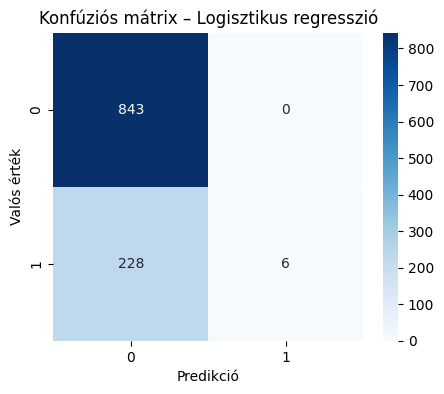

In [ ]:
# MI_beadandó_Juhász_Márton_Gábor_KH7OEY_BSc_Táv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adatok beolvasása
adat = pd.read_csv("Top-50-musicality-global.csv")

# Oszlopnevek egységesítése
adat.columns = [c.lower().replace(" ", "_") for c in adat.columns]

# EDA nekem: első sorok, info és statisztikák
print(adat.head())
print(adat.info())
print(adat.describe())

# Popularity eloszlásának megjelenítése
plt.figure(figsize=(8,4))
adat["popularity"].hist(bins=10)
plt.title("Popularity eloszlása")
plt.show()

# Korrelációs mátrix kirajzolása
plt.figure(figsize=(9,7))
szam_oszlopok = adat.select_dtypes(include=[np.number])
sns.heatmap(szam_oszlopok.corr(), cmap="coolwarm")
plt.title("Korrelációs mátrix")
plt.show()

# Célváltozó létrehozása. Felső 20% az 1.
hatar = np.percentile(adat["popularity"], 80)
adat["y"] = (adat["popularity"] >= hatar).astype(int)

print("Osztályarány:")
print(adat["y"].value_counts())

# Csak numerikus adatok kiválasztása
adat_num = adat.select_dtypes(include=[np.number]).copy()

# Hiányzó értékek mediánnal való pótlása
for oszlop in adat_num.columns:
    if adat_num[oszlop].isna().sum() > 0:
        adat_num[oszlop] = adat_num[oszlop].fillna(adat_num[oszlop].median())

# Jellemzők meghatározása az y-t és popularity-t kivéve
jellemzok = [c for c in adat_num.columns if c not in ["y", "popularity"]]

X = adat_num[jellemzok].values
y = adat_num["y"].values

# Train-test felosztás (70-30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Skálázás a logisztikus regresszióhoz
from sklearn.preprocessing import StandardScaler
sk = StandardScaler()
X_train_s = sk.fit_transform(X_train)
X_test_s = sk.transform(X_test)

# Modell 1: Logisztikus regresszió
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_s, y_train)

lr_proba = lr.predict_proba(X_test_s)[:,1]
lr_pred = (lr_proba > 0.5).astype(int)

# Modell 2: Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=120, random_state=0)
rf.fit(X_train, y_train)

rf_proba = rf.predict_proba(X_test)[:,1]
rf_pred = (rf_proba > 0.5).astype(int)

# Eredmények kiírása
from sklearn.metrics import accuracy_score, roc_auc_score

print("LR accuracy:", accuracy_score(y_test, lr_pred))
print("LR AUC:", roc_auc_score(y_test, lr_proba))

print("RF accuracy:", accuracy_score(y_test, rf_pred))
print("RF AUC:", roc_auc_score(y_test, rf_proba))

# Random Forest finomhangolás (próbálkozás)
from sklearn.model_selection import GridSearchCV

param = {
    "n_estimators": [80, 120],
    "max_depth": [None, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param,
    cv=3,
    scoring="roc_auc"
)

rf_grid.fit(X_train, y_train)

print("RF legjobb paraméterek:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
rf_best_proba = rf_best.predict_proba(X_test)[:,1]
print("RF finomhangolt AUC:", roc_auc_score(y_test, rf_best_proba))

# Konfúziós mátrix logisztikus regresszióra
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Konfúziós mátrix – Logisztikus regresszió")
plt.xlabel("Predikció")
plt.ylabel("Valós érték")
plt.show()


In [ ]:
print(lr_proba)

[0.16628353 0.09348957 0.22060399 ... 0.23085517 0.20950743 0.11438051]


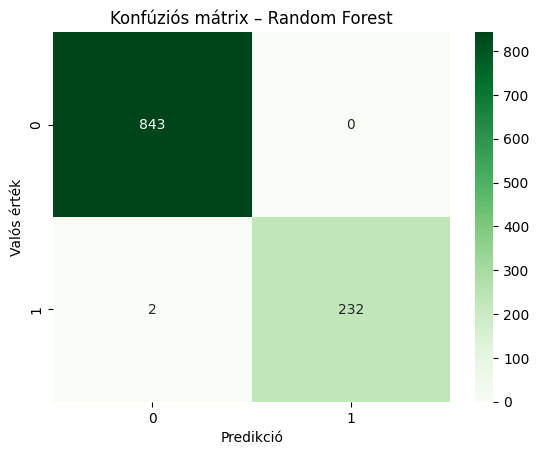

In [ ]:
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, cmap="Greens", fmt="d")
plt.title("Konfúziós mátrix – Random Forest")
plt.xlabel("Predikció")
plt.ylabel("Valós érték")
plt.show()